<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Neuroscience of Learning, Memory, Cognition <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    Spring 2024<br>
<font color=3C99D size=5>

<font color=696880 size=4>

---
# Finetuning CNN using regression loss

- CNN are proven to be a better model of visual cortex, but the goal of visual cortex is not limited to image classification.

- Typically, to model visual cortex responses using CNNs, we -

  1. Extract features of intermediate layers
  2. Reduce dimensionality of the data using techniques like PCA
  3. Perform regression to predict neural data.

- This approach fails to predict all the variance in the data.

**A better approach is to train CNNs directly on the neural response.**

- CNNs are built to somehow mimic the functionality of the visual system. They are able to achieve a high performance on many tasks, that were previously believed to be impossible for machines to solve. We are going to explore them in this assignment.

    1. Explain about the visual system, focusing on the data flow (You should explain the pathways in the visual system).

    2. What does each part of the visual system reveal about the stimuli (You should explain about the features that each part detects, like lines, angles, ...)?

    3. Compare the CNNs with the visual system. How are they alike and in which parts, do they converge?

    4. Explain about different learning strategies that we can deploy on the neural networks. What learning strategies have neurological evidence?

Answer:
1.
The visual pathway describes the anatomical pathway by which electrical signals generated by the retina are sent to the brain.
The nerve fibers of the retina, representing the axons of the ganglion cells, collect together at the optic disk before passing out of the eye through the orbital bones and into the brain via the optic nerve. At the end of each optic tract, the retinal nerve fibers connect with other visual pathway nerves in a structure called the lateral geniculate nucleus (LGN) located in the midbrain. Some processing of the electrical signals occurs in the LGN before a series of radiating nerve fibers, the optic radiation, convey the information to the visual cortex in the posterior portion of the occipital lobe. Perception of sight ultimately derives from processing within this and adjacent areas of brain. Most of the optic nerve fibers end in the lateral geniculate nucleus (LGN). Before the LGN forwards the pulses to V1 of the visual cortex (primary) it gauges the range of objects and tags every major object with a velocity tag. These tags predict object movement.
The LGN also sends some fibers to V2 and V3.

2.
V1 performs edge-detection to understand spatial organization ,initially, 40 milliseconds in, focusing on even small spatial and color changes.
Simple cells are neurons found in the primary visual cortex (V1) that have elongated receptive fields. They respond to edges and lines of a specific orientation within their receptive field.
Complex cells are also located in the primary visual cortex and have larger receptive fields than simple cells. They respond to edges and lines of a specific orientation within a broader range of their receptive field. Complex cells do not have strict spatial alignment requirements
V2 both forwards (direct and via pulvinar) pulses to V1 and receives them. Pulvinar is responsible for saccade and visual attention. V2 serves much the same function as V1, however, it also handles illusory contours, determining depth by comparing left and right pulses (2D images), and foreground distinguishment.
Hypercomplex cells, also known as end-stopped cells, are neurons in V1 that have receptive fields with inhibitory regions at both ends. They are sensitive to the length of edges or curves within their receptive field.

3.
Both CNNs and the visual system process information in a hierarchical manner. In CNNs, lower layers detect simple features like edges and textures, while higher layers combine these features to recognize more complex patterns and objects. Therefore, one of the main similarities between both systems lie in the hierarchial information processing.
Another common feature is spatial invariance. In both CNN and visual systems objects are recognized regardless of their position in input field. Besides, Neurons in both CNNs and the visual system exhibit selectivity to specific visual features. In CNNs, neurons in higher layers become increasingly selective to complex patterns and objects, similar to how neurons in the visual system respond selectively to specific orientations, colors, and shapes.

4.
There are several strategies employed to describe or model the behaviour of neural network and it's essential functions. The most common strategies are Hebbain learning, backpropogation, synaptic plasticity(LTD and LTP), reinforcement learning and spiking neural networks(SNN). Among these models, only backpropogation model does not provide plausible evidence for neurobiological basis.
For instance, Hebbian learning is a biological-inspired learning rule based on the principle that "cells that fire together, wire together."
Reinforcement learning, a paradigm where agents learn to take actions in an environment to maximize a reward signal, has strong biological foundations.

In [ ]:
# @title Install dependencies
!pip install Pillow --quiet
!pip install torch_intermediate_layer_getter --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
#  Imports
import copy

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter

from torchvision import transforms
import torchvision.models as models

from scipy.spatial.distance import pdist
from scipy.stats import pearsonr

# Add more if you need
import matplotlib.pyplot as plt

In [ ]:
# @title Downloading Kay dataset
import requests

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]

urls =['https://osf.io/r638s/download',
       'https://osf.io/yqb3e/download',
       'https://osf.io/ymnjv/download']

for i, url in enumerate(urls):
  r = requests.get(url, allow_redirects=True)
  with open(fnames[i], 'wb') as fh:
    fh.write(r.content)


with np.load(fnames[2]) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

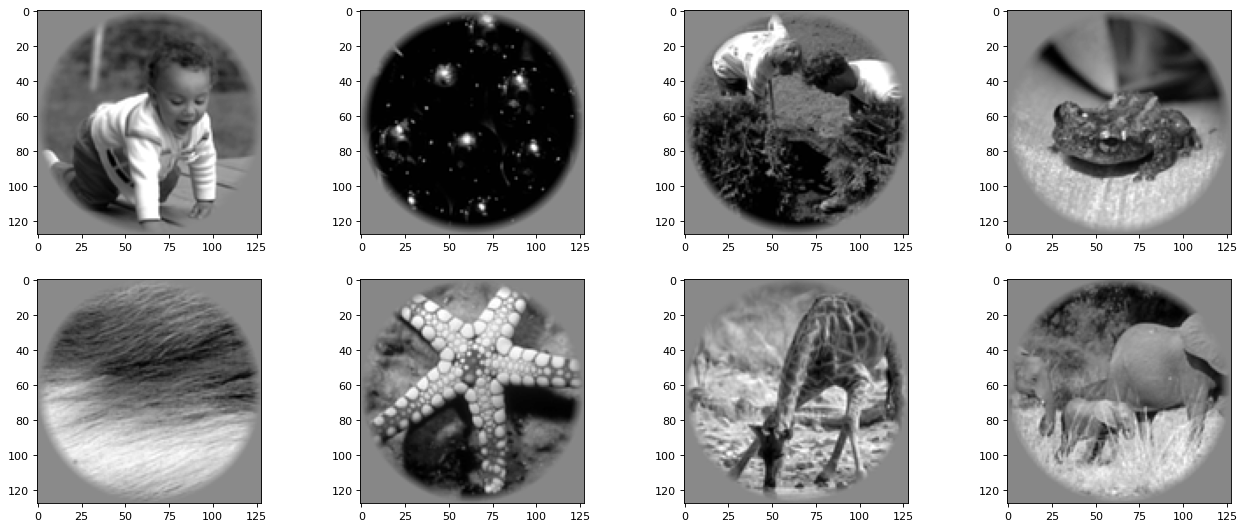

In [ ]:
# @title Visualizing example images
plt.figure(figsize=(20, 8), dpi=80)
for i in range(1,9):
  plt.subplot(2,4,i)
  plt.imshow(dat['stimuli'][i-1], cmap = 'gray')

---
# Dataset Structure

In [ ]:
# Converting stimulus to RGB and changing the scale to 0-255 (Specific to Kay dataset images)
stimuli_tr = dat["stimuli"]
stimuli_ts = dat["stimuli_test"]
stimuli_tr_xformed = np.zeros((1750, 3, 128, 128),dtype=np.uint8)
stimuli_ts_xformed = np.zeros((120, 3, 128, 128),dtype=np.uint8)

max_stimuli_tr = np.max(stimuli_tr)
min_stimuli_tr = np.min(stimuli_tr)

stimuli_tr = (255*(stimuli_tr-min_stimuli_tr)/(max_stimuli_tr-min_stimuli_tr)).astype(np.uint8)
for i in range(3):
  stimuli_tr_xformed[:,i,:,:] = stimuli_tr

max_stimuli_ts = np.max(stimuli_ts)
min_stimuli_ts = np.min(stimuli_ts)

stimuli_ts = ((stimuli_ts-min_stimuli_ts)/(max_stimuli_tr-min_stimuli_tr)).astype(np.uint8)
for i in range(3):
  stimuli_ts_xformed[:,i,:,:] = stimuli_ts

---
# Fine Tuning AlexNet on voxel activations





In [ ]:
# @title Setting up training and test data for LOC region (roc = 7)
############## TO DO ###############
response_tr = dat['responses'][:,np.where((dat['roi']==7))[0]]
response_ts = dat['responses_test'][:,np.where((dat['roi']==7))[0]]

In [ ]:
# @title Custom dataloader for loading images in numpy array
# use MyDatast or use your own dataloader.
class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None):
    self.data = data
    self.targets = torch.LongTensor(targets)
    self.transform = transform

  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]

    if self.transform:
        x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1, 2, 0))
        x = self.transform(x)

    return x, y

  def __len__(self):
      return len(self.data)

# complete transforms
transform = {
    'train': transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                                             std=[0.2023, 0.1994, 0.2010],)]),
    'val': transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                                             std=[0.2023, 0.1994, 0.2010],)]),
             }

dataset = {}
dataset['train'] = MyDataset(list(stimuli_tr_xformed),
                             list(response_tr), transform=transform['train'])
dataset['val'] = MyDataset(list(stimuli_ts_xformed),
                           list(response_ts), transform=transform['val'])
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=100) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Training on pretrained alexnet and find best wieghts on epochs,
#finally load best weights

# Define the custom model
class CustomModel(nn.Module):
    def __init__(self, output_size):
        super(CustomModel, self).__init__()

        # Load pre-trained AlexNet model
        self.alexnet = models.alexnet(pretrained=True)
        for param in self.alexnet.parameters():
            param.requires_grad = False

        # Remove the last classifier layer
        self.alexnet.classifier = nn.Sequential(*list(self.alexnet.classifier.children())[:-1])

        self.fc3 = nn.Linear(4096, output_size)
        self.tanh= nn.Tanh()
    def forward(self, x):
        x = self.alexnet(x)
        x = self.fc3(x)
        #x= 7*(self.tanh(x))
        return x


output_size = 928
num_epochs = 50
model = CustomModel(output_size)
model = model.to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

for epoch in range(num_epochs):
    for i, (images, outputs) in enumerate(dataloaders['train']):
        # Move tensors to the configured device
        outputs = outputs.float()
        images = images.to(device)
        outputs = outputs.to(device)

        # Forward pass
        outputs_pred = model(images)
        loss = criterion(outputs_pred, outputs)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #print ('Epoch [{}/{}], Loss: {:.4f}'
    #               .format(epoch+1, num_epochs, loss.item()))

    # Validation
    with torch.no_grad():
        counter = 0
        Loss_val = 0
        for images, outputs in dataloaders['val']:
            outputs = outputs.float()
            counter +=1
            images = images.to(device)
            outputs = outputs.to(device)
            outputs_pred = model(images)
            Loss_val += criterion(outputs_pred, outputs).item()
            del images, outputs_pred, outputs

        print ('Epoch [{}/{}] on Validation data, Loss: {:.4f}'
                   .format(epoch+1, num_epochs, Loss_val/counter))

        counter = 0
        Loss_val = 0
        for images, outputs in dataloaders['train']:
            outputs = outputs.float()
            counter +=1
            images = images.to(device)
            outputs = outputs.to(device)
            outputs_pred = model(images)
            Loss_val += criterion(outputs_pred, outputs).item()
            del images, outputs_pred, outputs

        print ('Epoch [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, Loss_val/counter))

Epoch [1/50] on Validation data, Loss: 0.1691
Epoch [1/50], Loss: 0.6148
Epoch [2/50] on Validation data, Loss: 0.1647
Epoch [2/50], Loss: 0.5296
Epoch [3/50] on Validation data, Loss: 0.1646
Epoch [3/50], Loss: 0.4798
Epoch [4/50] on Validation data, Loss: 0.1555
Epoch [4/50], Loss: 0.4495
Epoch [5/50] on Validation data, Loss: 0.1644
Epoch [5/50], Loss: 0.4219
Epoch [6/50] on Validation data, Loss: 0.1680
Epoch [6/50], Loss: 0.4022
Epoch [7/50] on Validation data, Loss: 0.1701
Epoch [7/50], Loss: 0.3897
Epoch [8/50] on Validation data, Loss: 0.1729
Epoch [8/50], Loss: 0.3848
Epoch [9/50] on Validation data, Loss: 0.1866
Epoch [9/50], Loss: 0.3730
Epoch [10/50] on Validation data, Loss: 0.1946
Epoch [10/50], Loss: 0.3669
Epoch [11/50] on Validation data, Loss: 0.2032
Epoch [11/50], Loss: 0.3616
Epoch [12/50] on Validation data, Loss: 0.2020
Epoch [12/50], Loss: 0.3598
Epoch [13/50] on Validation data, Loss: 0.2051
Epoch [13/50], Loss: 0.3532
Epoch [14/50] on Validation data, Loss: 0.2